## Purpose of Notebook

Simple extensions to the JMAK and GL isothermal model recrystillizations are presented for the non-isothermal recrystillization case in this notebook. In general, available measurements for recystillization of tungsten come from isothermal experiments. If the operating state of the fusion nuclear reactor equipment is steady, this condition is met perfectly. In the _transient_ case, and more generally speaking, when the temperature $T(t,\mathbf{x}): \{\mathcal{T} \times \mathcal{X} \} \to \mathbb{R}$  where $\mathcal{T}  \subseteq \mathbb{R}_+, \mathcal{X} \subseteq \mathbb{R}^3$ in the component is _not_ independent of time, the isothermal recrystillization model cannot accomodate this behavior. The notation $T(t,\mathbf{x})$ is replaced by $T(t)$ to simplify the equations, with the connotation being some temperature function at an unspecified point.

### Non-isothermal Recrystillization Assumptions
Let $Y(t)$ be the _Non_-isothermal recrystillization fraction (_vs._ the isothermal fraction $X(t)$ considered when fitting the model) with some aribitrary temperature function $T(t)$. Following [1] we assume that:

1. The _rate_ of recrystillization is equal to the rate of isothermal recrystillization at the same recrystillization fraction $Y(t)$ and temperature $T$.
2. Temperature is essentially constant over a small enough time interval, and therefore the non-isothermal recrystillization behavior is not a function of the $T^\prime(t)$

### RXMAT Discrete Model 
The RXMAT model [1] for non-isothermal recrystillization begins with the JMAK model. Let $t_n$ denote a discrete time series of length $n$. The non-isothermal recrystillization has two phases: (1) incubation and (2) recrystillization. Let.

$
\rho(t_n) = \sum_{i = 1}^n \frac{\Delta t_i}{t_{inc}(T(t_i))}
$

for $\rho(t_n) < 1$ the material is in the incubation phase and $Y(t_n) = 0$. For recrystillization, the two step process is used:

#### Step 1.
Invert the JMAK equation to get the effective time:

$
\tau = - \frac{\left( \ln{(1 - Y(t_i))}\right)^{1/n}}{b(T(t_i + \Delta t_i))}
$

#### Step 2.
Get the contribution to recrystillization fraction $Y$ over interval $\Delta t_i$. 

$
Y(t_i + \Delta t_i) = 1 - \exp(-b(T(t_i + \Delta t_i))^n (\tau + \Delta t_i)^n)
$

[1] A. Durif, M. Richou, G. Kermouche, J. M. Bergheau, "Numerical study of the influence of tungsten recrystallization on the divertor component lifetime" (2021).


### Continuous JMAK model

The RXMAT model satisfies the two assumptions above and implies the following continuous time solution:

$
Y(t)  = \begin{cases}
0 \qquad & t \leq t_0 \\ 
Y^{\dagger}(t - t_0) \qquad & t > t_0 \\ 
\end{cases} \\
t_0 = \rho^{-1}(1) \qquad \rho = \int \frac{d \tau}{t_{inc}(T(\tau))} \\ 
Y^{\dagger} = 1 - \exp{\left\{- \left( \int b(T(\tau)) d\tau \right)^n  \right\}} \\ 
$



### Continuous GLM model

Using the GLM model to derive an analogous discrete expression for non-isothermal recrystillization, we then arrive at the following expression for continuous non-isothermal recrystillization:

$
Y(t) = \left( \frac{1}{1 + C\exp{\left(-\int B(T(\tau)) d\tau\right)}} \right)^{1/\nu} \\ 
$

$
C = \left( \frac{1}{Y_0^\nu} - 1 \right) \exp{\left( B_0 M_0 \right)}\\ 
Y_0 = \left( \frac{1}{1 + \exp{\left( B_0 M_0 \right)}} \right)^{1/\nu}
$

Where $B_0 = B(T(0)), M_0 = M(T(0))$. Using numerical integration for both the JMAK and GLM models is convinient rather than deriving explicit forms as in applications, an analytical expression for $T$ will rarely be available, and interpolating functions of discrete temperature series will be used. These routines, along with the RXMAT equivalents are implemented in the below cell.

In [70]:
import numpy as np
from matplotlib import pyplot as plt
import math
import pickle
from typing import Callable
from scipy.integrate import quad
from scipy.optimize import bisect
from scipy.integrate import solve_ivp
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('.')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
sys.path.append(str(PARENT_DIR))

from common_util import setup_axis_default, LogLinearArrheniusModelFunc, LogLinearArrhenius,jmak_function, generalized_logistic
import pandas as pd

data_label = 'Lopez et al. (2015) - MR'

jmak_model_params = pd.read_csv(
    INFERENCE_PATH.joinpath('JMAK_' + data_label + '_params.csv'),
    index_col = 0).loc[['a1','B1','a2','B2','n'],'ml'].values

gl_model_params = pd.read_csv(
    INFERENCE_PATH.joinpath('Generalized Logistic_' + data_label + '_params.csv'),
    index_col = 0).loc[['a1','B1','a2','B2','nu'],'ml'].values    

jmak_model = LogLinearArrheniusModelFunc(jmak_function,n = jmak_model_params[-1],
                                         ap1 = LogLinearArrhenius(jmak_model_params[0:2]),
                                         ap2 = LogLinearArrhenius(jmak_model_params[2:4]))

gl_model = LogLinearArrheniusModelFunc(generalized_logistic,n = gl_model_params[-1],
                                        ap1 = LogLinearArrhenius(gl_model_params[0:2]),
                                        ap2 = LogLinearArrhenius(gl_model_params[2:4]))


def _default_ode_kwargs(**kwargs):
    """ 
    favor precision over speed.
    """

    default_kwargs = {'method':'DOP853',
                      'rtol':1e-12,
                      'atol':1e-12}
    
    default_kwargs.update(kwargs)
    return default_kwargs

def nonisothermal_jmak_rx_integration(t: np.ndarray,
                                      T: Callable,
                                      jmak_params: np.ndarray,
                                      **solver_kwargs):
    

    """"
    numerically integrate the JMAK model with non-isothermal conditions, assuming no 
    temperature rate effects.
    """

    a1,B1,a2,B2,n = jmak_params

    def b(Temp: float):
        return math.exp(a1 + B1/Temp)
    
    def tinc(Temp: float):
        return math.exp(a2 + B2/Temp)
    
    def find_start_t():
        
        def rho_func(tt: float):
            return quad(lambda x: 1./tinc(T(x)),0,tt)[0] - 1.   
        
        return bisect(rho_func,t[0],t[-1])
    
    start_t = find_start_t()
    
    def integrate_func(tt: float,_):
        TT = T(tt + start_t)    
        BB = b(TT)
        return BB

    Y = np.zeros_like(t)
    
    index = t > start_t
    solver_kwargs = _default_ode_kwargs(**solver_kwargs)
    Z = solve_ivp(integrate_func,(t[0],t[-1]),np.array([1e-18]),
                         t_eval = (t[index] - start_t),**solver_kwargs)['y'].squeeze()**n  

    Y[index] = 1. - np.exp(-Z)
    return Y

def nonisothermal_glm_rx_integration(t: np.ndarray,
                                      T: Callable,
                                      glm_params: np.ndarray,
                                      **solver_kwargs):
    
    """"
    numerically integrate the GLM model with non-isothermal conditions, assuming no 
    temperature rate effects.
    """
    a1,B1,a2,B2,nu = glm_params
    
    def B(Temp: float):
        return math.exp(a1 + B1/Temp)
    
    def integrate_func(tt: float, _: float):
        TT = T(tt)
        BB = B(TT)
        return BB

    M0 = math.exp(a2 + B2/T(t[0]))
    B0 = B(T(t[0]))
    Phi0 = math.exp(M0*B0)
    Y0 = (1 + Phi0)**(-1./nu)
    Y0 = max(1e-18,Y0)
    C = (1/Y0**nu  - 1) *Phi0 

    solver_kwargs = _default_ode_kwargs(**solver_kwargs)
    Z = solve_ivp(integrate_func,(t[0],t[-1]),np.array([M0*B0]),
                         t_eval = t,
                         **solver_kwargs)['y'].squeeze()  
    
    Y = (1. + C*np.exp(-Z))**(-1/nu)

    return Y

def nonisothermal_jmak_rxmat_integration(t: np.ndarray,
                                         T: np.ndarray,
                                         jmak_params: np.ndarray):
    
    """
    integrate the JMAK model with non-isothermal conditions, taking the discrete appraoch
    of the RXMAT model.
    """

    a1,B1,a2,B2,n = jmak_params

    def b(Temp: float):
        return math.exp(a1 + B1/Temp)
    
    def tinc(Temp: float):
        return math.exp(a2 + B2/Temp)
    
    def find_start_index() -> int:

        rho = t[0]/tinc(T[0])
        index = 1
        rho_old = 0.0
        while index < t.shape[0] and rho < 1.:
            dt = t[index] - t[index-1]
            rho_old = rho
            rho += dt/tinc(T[index])
            index += 1
        
        m = (rho - rho_old)/dt
        tt = (1. - rho_old)/m
        return index, tt

    index,t_init = find_start_index()
    t_growth = t - t[index] + t_init    
    Y = np.zeros_like(t)

    bb = b(T[index])
    Y[index] = 1. - math.exp(-(bb**n)*t_init**n) 

    for i in range(index+1,len(t_growth)):
        bb = b(T[i])
        t_equiv = 1./bb*np.log(1./(1. - Y[i-1]))**(1./n)
        dt = t_growth[i] - t_growth[i-1]

        Y[i] = 1. - math.exp(-bb**n*(dt + t_equiv)**n)
    
    return Y

def nonisothermal_glm_rxmat_integration(t: np.ndarray,
                                  T: np.ndarray,
                                  glm_params: np.ndarray):
    
    """
    integrate the GLM model with non-isothermal conditions, taking the discrete appraoch
    of the RXMAT model.
    """

    a1,B1,a2,B2,nu = glm_params 

    def B(Temp: float):
        return math.exp(a1 + B1/Temp)
    
    def M(Temp: float):
        return math.exp(a2 + B2/Temp)
    
    Y = np.zeros_like(t)

    Y[0] = (1. + np.exp(-B(T[0])*(t[0] - M(T[0]))))**(-1/nu)
    Y[0] = max(1e-18,Y[0])
    for i in range(1,t.shape[0]):
        MM = M(T[i])
        BB = B(T[i])

        t_equiv = MM - 1./BB*np.log(Y[i-1]**(-nu) - 1)
        dt = t[i] - t[i-1]
        Y[i] = 1/((1. + np.exp(-BB*(dt + t_equiv - MM)))**(1/nu))
    
    return Y



# Model Validation
We will focus our attention on validating the numerical model here, to ensure consistency with our assumptions. Validating the ability of this model to match experimental data is beyond the scope of this project. We can ensure at least that a continuous versions of the RXMAT discrete model agreees with the discrete cases. 

We test the following:
1. Agreement with isothermal case
2. Agreement with discrete jump temperature case
3. Visualization of simple temperature profiles

### 1. Agreement with Isothermal Case - JMAK
As seen below, both non-isothermal models are consistent with the isothermal model for constant temperature. This is the barest level of agreement we should expect.

e:\ORNL Collaboration\System Design\ASME Code\modeling_tungsten\recrystallization\common_util.py:258: RuntimeWarning: invalid value encountered in power
  1.0 - np.exp(-b**n*(t - t_inc)**n)


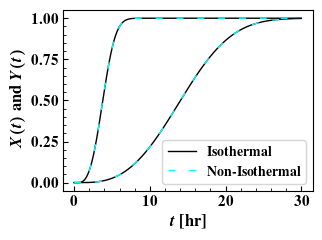

In [ ]:
t_eval = np.linspace(0,30*3600,100)
t_func = np.linspace(0.,30*3600,1000)

fig,ax = plt.subplots(figsize = (3.25,2.5))
setup_axis_default(ax)

for i,T in enumerate([1300,1350]):
    T_iso = T + 273.15
    Y = nonisothermal_jmak_rx_integration(t_eval, lambda x: T_iso, jmak_model_params)
    X = jmak_model.predict(np.array([t_func,T_iso*np.ones_like(t_func)]).T)
    ax.plot(t_func/3600,X,label = r'\textbf{Isothermal}' if i == 0 else None,lw = 1.0,color = 'k',ls = '-')
    ax.plot(t_eval/3600,Y,label = r'\textbf{Non-Isothermal}' if i == 0 else None,lw = 1,color = 'cyan',ls = '--',dashes = (5,10))

ax.set_xlabel(r'\textbf{$t$ [hr]}',fontsize = 12)
ax.set_ylabel(r'$X(t)$ \textbf{and} $Y(t)$',fontsize = 12)

ax.legend(fontsize = 10)
fig.tight_layout()

### 1. Agreement with Isothermal Case - GLM

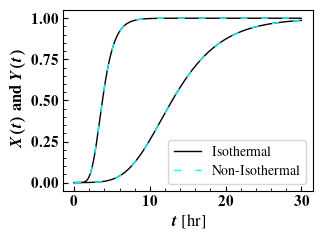

In [63]:
t_eval = np.linspace(0,30*3600,100)
t_func = np.linspace(0.,30*3600,1000)


fig,ax = plt.subplots(figsize = (3.25,2.5))
setup_axis_default(ax)

for i,T in enumerate([1300,1350]):
    T_iso = T + 273.15
    Y = nonisothermal_glm_rx_integration(t_eval, lambda x: T_iso, gl_model_params)
    X = gl_model.predict(np.array([t_func,T_iso*np.ones_like(t_func)]).T)
    ax.plot(t_func/3600,X,label = 'Isothermal' if i == 0 else None,lw = 1.0,color = 'k',ls = '-')
    ax.plot(t_eval/3600,Y,label = 'Non-Isothermal' if i == 0 else None,lw = 1,color = 'cyan',ls = '--',dashes = (5,10))

ax.set_xlabel('$t$ [hr]',fontsize = 12)
ax.set_ylabel(r'$X(t)$ \textbf{and} $Y(t)$',fontsize = 12)

ax.legend(fontsize = 10)
fig.tight_layout()

### 2. Discrete Jumps - JMAK

We can use a step temperature function to better visualize the "jumps" in the rate of the recrystillization over time 
Suppose that:

$
T(t) = \begin{cases}
T_1 \qquad & 0 \leq t < t_1 \\ 
T_2 \qquad & t_1 \leq t < t_2 \\
T_3 \qquad & t \geq t_2
\end{cases}
$

The below demonstrates what happens when the temperature "switches". For each of these models, it's the same and the rate increases corresponding to the increasing temperature. The lower left plot shows the temperature profile over time, while the rightmost plot shows the isocurves for the chosen fixed temperatures, and the "transitions" between these jump curves.

e:\ORNL Collaboration\System Design\ASME Code\modeling_tungsten\recrystallization\common_util.py:258: RuntimeWarning: invalid value encountered in power
  1.0 - np.exp(-b**n*(t - t_inc)**n)


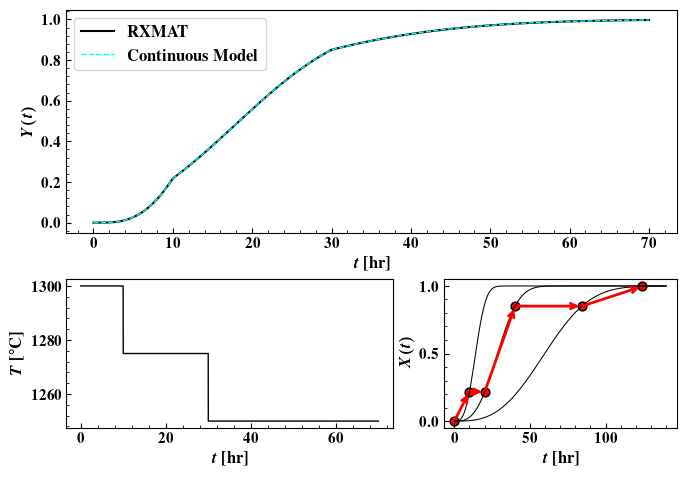

In [44]:
t_1 = 10.0*3600
t_2 = 30.0*3600
t_3 = 70.0*3600
T1 = 1300.0 + 273.15
T2 = 1275.0 + 273.15
T3 = 1250. + 273.15

def jump_temperature(t: float):

    if t < t_1:
        return T1
    elif t > t_1 and t < t_2:
        return T2
    else:
        return T3
    
t_eval = np.linspace(0,t_3,100000)

fig,axes = plt.subplot_mosaic("""
                              AAAAAAA
                              BBBBCCC
                              """,
                              height_ratios= [1.5,1],
                              figsize = (6.5,4.75))

axes = np.array(list(axes.values()))
for ax in axes.ravel():
    setup_axis_default(ax)

# plot overall recrystillization profiles
Y_disc = nonisothermal_jmak_rxmat_integration(t_eval,np.array([jump_temperature(t) for t in t_eval]),jmak_model_params)
axes[0].plot(t_eval/3600,Y_disc,lw = 1.5,color = 'k',ls = '-', label = r'\textbf{RXMAT}')

Y_cont = nonisothermal_jmak_rx_integration(t_eval,jump_temperature,jmak_model_params)
axes[0].plot(t_eval/3600,Y_cont,lw = 1,color = 'cyan',ls = '--', label = r'\textbf{Continuous Model}')

#plot the temperature profile
axes[1].plot(t_eval/3600,[jump_temperature(t) - 273.15 for t in t_eval],lw = 1,color = 'k',ls = '-')
axes[1].set_ylabel(r'\textbf{$T$ [$^\circ$C]}',fontsize = 12)
axes[1].set_xlabel(r'\textbf{$t$ [hr]}',fontsize = 12)

t_eval = np.linspace(0,t_3*2,10000)
#plot the isothermal models and note the "jump" points between rates
X = jmak_model.predict(np.array([[t_1,T1]])).squeeze()
Xp = jmak_model.predict(np.array([t_eval,np.ones_like(t_eval)*T1]).T)
axes[2].scatter(t_1/3600,X,marker = 'o',color = 'red',s = 40,edgecolor = 'k')
axes[2].scatter(0.0,0.0,marker = 'o',color = 'red',s = 40,edgecolor = 'k')
axes[2].plot(t_eval/3600,Xp,lw = 0.75,color = 'k',ls = '-')
axes[2].annotate('', xy=(t_1/3600, X), xytext=(0.0,0.0),
                    arrowprops=dict(arrowstyle='->', color='red',lw = 2.0))

a1,b1 = jmak_model.ap1.params
a2,b2 = jmak_model.ap2.params
n = jmak_model.n

t_old = t_1
for dt,TT in zip([t_2 - t_1,t_3 - t_2],[T2,T3]):
    bb = math.exp(a1 + b1/TT)
    tinc = math.exp(a2 + b2/TT)

    t_equiv = 1./bb*np.log(1./(1. - X))**(1./n)
    t_current = dt + t_equiv
    axes[2].scatter((t_equiv + tinc)/3600,X,marker = 'o',color = 'red',s = 40,edgecolor = 'k')

    axes[2].annotate('', xy=((t_equiv + tinc)/3600, X), xytext=(t_old/3600, X),
                     arrowprops=dict(arrowstyle='->', color='red',lw = 2.0))
    
    Xnew = 1. - math.exp(-(bb**n)*t_current**n)
    
    axes[2].scatter((t_current + tinc)/3600,Xnew,marker = 'o',color = 'red',s = 40,edgecolor = 'k')
    Xp = jmak_model.predict(np.array([t_eval,np.ones_like(t_eval)*TT]).T)
    axes[2].plot(t_eval/3600,Xp,lw = 0.75,color = 'k',ls = '-')
    axes[2].annotate('', xy=((t_current + tinc)/3600, Xnew), xytext=((t_equiv + tinc)/3600, X),
                     arrowprops=dict(arrowstyle='->', color='red',lw = 2.0))
    X = Xnew
    t_old = t_current + tinc

axes[0].set_xlabel(r'\textbf{$t$ [hr]}',fontsize = 12)
axes[0].set_ylabel(r'$Y(t)$',fontsize = 12)
axes[2].set_xlabel(r'\textbf{$t$ [hr]}',fontsize = 12)
axes[2].set_ylabel(r'$X(t)$',fontsize = 12)
axes[0].legend(fontsize = 12)   

fig.subplots_adjust(hspace = 0.25,top = 0.98,right = 0.99,left = 0.05,bottom = 0.1,wspace = 1.15)
fig.savefig(GIT_IMAGE_PATH.joinpath('nonisothermal_rxmat.svg'),bbox_inches = 'tight')


### 2. Discrete Jumps - GLM

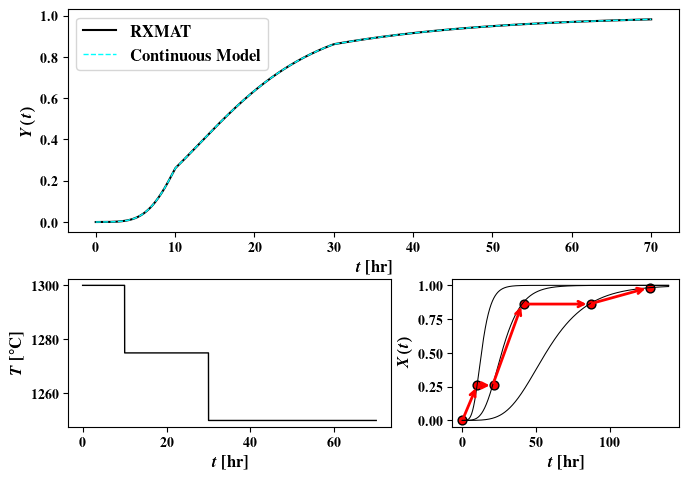

In [64]:
t_1 = 10.0*3600
t_2 = 30.0*3600
t_3 = 70.0*3600
T1 = 1300.0 + 273.15
T2 = 1275.0 + 273.15
T3 = 1250. + 273.15

def jump_temperature(t: float):

    if t < t_1:
        return T1
    elif t > t_1 and t < t_2:
        return T2
    else:
        return T3
    
t_eval = np.linspace(0,t_3,100000)

fig,axes = plt.subplot_mosaic("""
                              AAAAAAA
                              BBBBCCC
                              """,
                              height_ratios= [1.5,1],
                              figsize = (6.5,4.75))

axes = np.array(list(axes.values()))

# plot overall recrystillization profiles
Y_disc = nonisothermal_glm_rxmat_integration(t_eval,np.array([jump_temperature(t) for t in t_eval]),gl_model_params)
axes[0].plot(t_eval/3600,Y_disc,lw = 1.5,color = 'k',ls = '-', label = r'\textbf{RXMAT}')

Y_cont = nonisothermal_glm_rx_integration(t_eval,jump_temperature,gl_model_params)
axes[0].plot(t_eval/3600,Y_cont,lw = 1,color = 'cyan',ls = '--', label = r'\textbf{Continuous Model}')

#plot the temperature profile
axes[1].plot(t_eval/3600,[jump_temperature(t) - 273.15 for t in t_eval],lw = 1,color = 'k',ls = '-')
axes[1].set_ylabel(r'\textbf{$T$ [$^\circ$C]}',fontsize = 12)
axes[1].set_xlabel(r'\textbf{$t$ [hr]}',fontsize = 12)
t_eval = np.linspace(0,t_3*2,10000)

#plot the isothermal models and note the "jump" points between rates
X = gl_model.predict(np.array([[t_1,T1]])).squeeze()
Xp = gl_model.predict(np.array([t_eval,np.ones_like(t_eval)*T1]).T)
axes[2].scatter(t_1/3600,X,marker = 'o',color = 'red',s = 40,edgecolor = 'k')
axes[2].scatter(0.0,0.0,marker = 'o',color = 'red',s = 40,edgecolor = 'k')
axes[2].plot(t_eval/3600,Xp,lw = 0.75,color = 'k',ls = '-')
axes[2].annotate('', xy=(t_1/3600, X), xytext=(0.0,0.0),
                    arrowprops=dict(arrowstyle='->', color='red',lw = 2.0))

a1,b1,a2,b2,nu = gl_model_params

t_old = t_1
for dt,TT in zip([t_2 - t_1,t_3 - t_2],[T2,T3]):
    BB = math.exp(a1 + b1/TT)
    MM = math.exp(a2 + b2/TT)
    
    t_equiv = MM - 1./BB*np.log(X**(-nu) - 1)
    t_current = dt + t_equiv
    axes[2].scatter((t_equiv + tinc)/3600,X,marker = 'o',color = 'red',s = 40,edgecolor = 'k')

    axes[2].annotate('', xy=(t_equiv/3600, X), xytext=(t_old/3600, X),
                     arrowprops=dict(arrowstyle='->', color='red',lw = 2.0))
    
    Xnew = 1/((1. + np.exp(-BB*(dt + t_equiv - MM)))**(1/nu))
    
    axes[2].scatter((t_current + tinc)/3600,Xnew,marker = 'o',color = 'red',s = 40,edgecolor = 'k')
    Xp = gl_model.predict(np.array([t_eval,np.ones_like(t_eval)*TT]).T)
    axes[2].plot(t_eval/3600,Xp,lw = 0.75,color = 'k',ls = '-')
    axes[2].annotate('', xy=(t_current/3600, Xnew), xytext=(t_equiv/3600, X),
                     arrowprops=dict(arrowstyle='->', color='red',lw = 2.0))
    X = Xnew
    t_old = t_current

axes[0].set_xlabel(r'\textbf{$t$ [hr]}',fontsize = 12)
axes[0].set_ylabel(r'$Y(t)$',fontsize = 12)
axes[2].set_xlabel(r'\textbf{$t$ [hr]}',fontsize = 12)
axes[2].set_ylabel(r'$X(t)$',fontsize = 12)
axes[0].legend(fontsize = 12)   

fig.subplots_adjust(hspace = 0.25,top = 0.98,right = 0.99,left = 0.05,bottom = 0.1,wspace = 1.75)



### 3. Temperature Profile Visualizations - JMAK

Finally we'll validate the continuous model against the RXMAT formulation for 3 time dependent temperature profiles.

1. linearly increasing 
2. linearly decreasing
3. An exponential profile

The results are shown below.


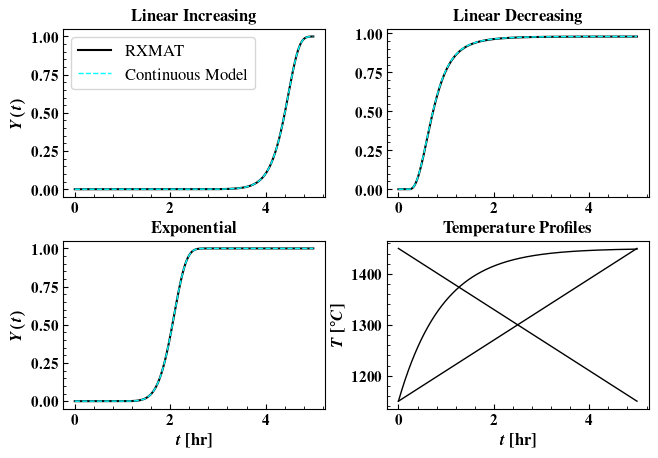

In [68]:
t_eval = np.linspace(0,5*3600,10000)
Tmin = 1150 + 273.15
Tmax = 1450 + 273.15
slope = (Tmax - Tmin)/(t_eval[-1] - t_eval[0])

temperature_funcs = [lambda x: Tmin + slope*x,
                     lambda x: Tmax - slope*x,
                     lambda x: (Tmax - Tmin) * (1- math.exp(-3e-4*x)) + Tmin]

titles = ['Linear Increasing','Linear Decreasing','Exponential']
fig,axes = plt.subplots(figsize = (6.5,4.5),nrows = 2,ncols = 2)
for ax in axes.ravel():
    setup_axis_default(ax)

for tfunc,ax,ax_title in zip(temperature_funcs,axes.ravel(),titles):

    Y_disc = nonisothermal_jmak_rxmat_integration(t_eval,[tfunc(tt) for tt in t_eval],jmak_model_params)
    ax.plot(t_eval/3600,Y_disc,lw = 1.5,color = 'k',ls = '-', label = 'RXMAT')

    Y_cont = nonisothermal_jmak_rx_integration(t_eval,tfunc,jmak_model_params)
    ax.plot(t_eval/3600,Y_cont,lw = 1,color = 'cyan',ls = '--', label = 'Continuous Model')

    ax.set_title(r'\textbf{' + ax_title + '}',fontsize = 12)

axes[0,0].legend(fontsize = 12)

for i in range(2):
    axes[1,i].set_xlabel(r'$t$ \textbf{[hr]}',fontsize = 12)
    axes[i,0].set_ylabel('$Y(t)$',fontsize = 12)

for tfunc in temperature_funcs:
    axes[-1,-1].plot(t_eval/3600,[tfunc(x) - 273.15 for x in t_eval],lw = 1,color = 'k')

axes[-1,-1].set_xlabel(r'$t$ \textbf{[hr]}',fontsize = 12)    
axes[-1,-1].set_ylabel(r'$T$ \textbf{[$^\circ C$]}',fontsize = 12)
axes[-1,-1].set_title(r'\textbf{Temperature Profiles}',fontsize = 12)

fig.tight_layout(pad = 0.4)
fig.savefig(GIT_IMAGE_PATH.joinpath('jmak_anisothermal_visualization.svg'),bbox_inches = 'tight')



### 3. Temperature Profile Visualizations - GLM

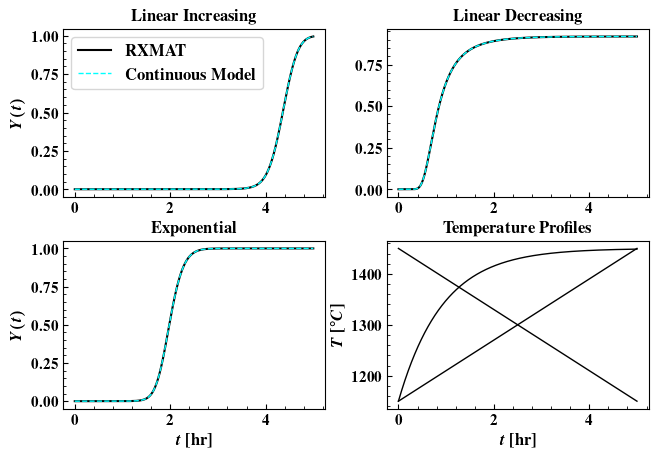

In [ ]:
t_eval = np.linspace(0,5*3600,100000)
Tmin = 1150.0 + 273.15
Tmax = 1450.0 + 273.15
slope = (Tmax - Tmin)/(t_eval[-1] - t_eval[0])

temperature_funcs = [lambda x: Tmin + slope*x,
                     lambda x: Tmax - slope*x,
                     lambda x: (Tmax - Tmin) * (1- math.exp(-3e-4*x)) + Tmin]

titles = ['Linear Increasing','Linear Decreasing','Exponential']
fig,axes = plt.subplots(figsize = (6.5,4.5),nrows = 2,ncols = 2)
for ax in axes.ravel():
    setup_axis_default(ax)

for tfunc,ax,ax_title in zip(temperature_funcs,axes.ravel(),titles):

    Y_disc = nonisothermal_glm_rxmat_integration(t_eval,[tfunc(tt) for tt in t_eval],gl_model_params)
    ax.plot(t_eval/3600,Y_disc,lw = 1.5,color = 'k',ls = '-', label = r'\textbf{RXMAT}')

    Y_cont = nonisothermal_glm_rx_integration(t_eval,tfunc,gl_model_params)
    ax.plot(t_eval/3600,Y_cont,lw = 1,color = 'cyan',ls = '--', label = r'\textbf{Continuous Model}')

    ax.set_title(r'\textbf{' + ax_title + '}',fontsize = 12)

axes[0,0].legend(fontsize = 12)

for i in range(2):
    axes[1,i].set_xlabel(r'$t$ \textbf{[hr]}',fontsize = 12)
    axes[i,0].set_ylabel('$Y(t)$',fontsize = 12)

for tfunc in temperature_funcs:
    axes[-1,-1].plot(t_eval/3600,[tfunc(x) - 273.15 for x in t_eval],lw = 1,color = 'k')

axes[-1,-1].set_xlabel(r'$t$ \textbf{[hr]}',fontsize = 12)    
axes[-1,-1].set_ylabel(r'$T$ \textbf{[$^\circ C$]}',fontsize = 12)
axes[-1,-1].set_title(r'\textbf{Temperature Profiles}',fontsize = 12)

fig.tight_layout(pad = 0.4)
fig.savefig(GIT_IMAGE_PATH.joinpath('jmak_anisothermal_visualization.svg'),bbox_inches = 'tight')



## Non-isothermal JMAK vs. GLM

As a final comparison, below is plotted the non-isothermal recrystillization fraction using both the JMAK and GLM derived models for the three temperature profiles, along with a constant temperature profile which is compared with Alfonso _et al.'s_  experimental data at $T = 1250 \ ^\circ C$. We can see that the GLM predicts a slightly slower isothermal recrystillization, which persists across the non-isothermal cases.

1250.0


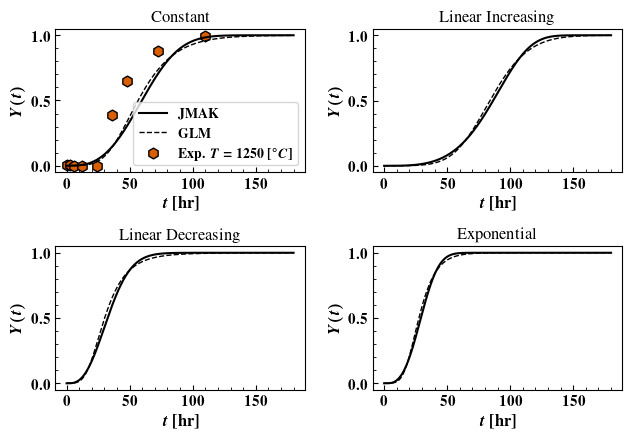

In [ ]:
import pandas as pd

t_eval = np.linspace(0,180*3600,10000)
Tmin = 1225 + 273.15
Tmax = 1275 + 273.15
slope = (Tmax - Tmin)/(t_eval[-1] - t_eval[0])

print((Tmin + Tmax)/2. - 273.15)
temperature_funcs = [lambda x: (Tmin + Tmax)/2.,
                     lambda x: Tmin + slope*x,
                     lambda x: Tmax - slope*x,
                     lambda x: (Tmax - Tmin) * (1- math.exp(-3e-4*x)) + Tmin]

titles = ['Constant','Linear Increasing','Linear Decreasing','Exponential']
fig,axes = plt.subplots(figsize = (6.5,4.5),nrows = 2,ncols = 2)
for ax in axes.ravel():
    setup_axis_default(ax)

for tfunc,ax,ax_title in zip(temperature_funcs,axes.ravel(),titles):

    Y_jmak = nonisothermal_jmak_rx_integration(t_eval,tfunc,jmak_model_params)
    ax.plot(t_eval/3600,Y_jmak,lw = 1.5,color = 'k',ls = '-', label = r'\textbf{JMAK}')

    Y_glm = nonisothermal_glm_rx_integration(t_eval,tfunc,gl_model_params)
    ax.plot(t_eval/3600,Y_glm,lw = 1,color = 'k',ls = '--', label = r'\textbf{GLM}')
    
    ax.set_title(r'\textbf{' + ax_title + '}',fontsize = 12)

for i in range(2):
    axes[1,i].set_xlabel(r'$t$ \textbf{[hr]}',fontsize = 12)
    axes[i,0].set_ylabel('$Y(t)$',fontsize = 12)

data_file = f'rf_data/alfonso_data/moderate_roll.csv'
data = pd.read_csv(data_file,index_col = 0)
data = data.loc[data['temperature'] == 1250]
data = data.loc[data['time'] <= t_eval.max()/3600]

axes[0,0].scatter(data['time'],data['X'],color = plt.get_cmap('Dark2')(0.2),
           marker = 'h',label = r'\textbf{Exp.} $T = 1250$ \textbf{[$^\circ C$]}',
           edgecolor = 'k',s = 60)

axes[0,0].legend(fontsize = 10)
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('jmak_glm_comparison.svg'),bbox_inches = 'tight')